**Importações**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

2022-06-18 12:34:04.898872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-18 12:34:04.898930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Baixar o dataset**

In [2]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

O conjunto de dados inclui **303 amostras** com **14 colunas por amostra** (**13 variáveis**, mais o rótulo de destino)





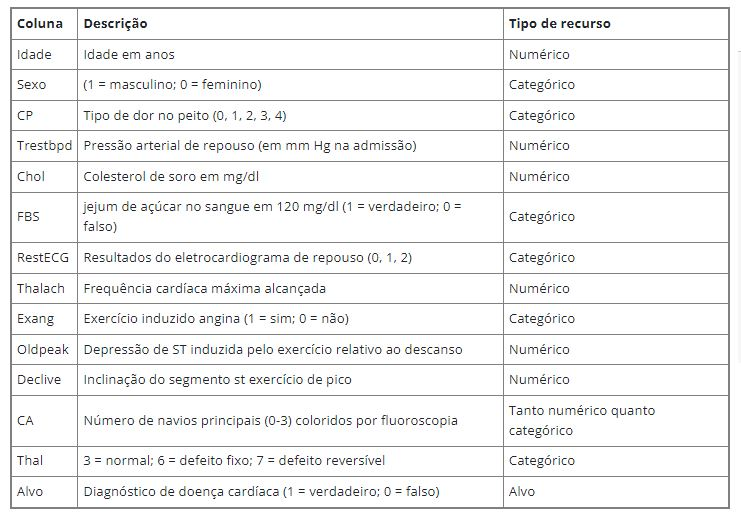


Fonte: Cleveland Clinic Foundation for Heart Disease (2020)

In [3]:
dataframe.shape

(303, 14)

**Mostrando algumas amostras**

In [4]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


A última coluna, "alvo", indica se o paciente tem uma doença cardíaca (1) ou não (0).
Agora dividimos o conjunto de dados entre treinamento e validação:

In [5]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Usar %d amostras para treinamento e %d para validação"
    % (len(train_dataframe), len(val_dataframe))
)

Usar 242 amostras para treinamento e 61 para validação


**Geramos o tf.data.Dataset para cada dataframe**

In [6]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2022-06-18 12:34:39.451593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-18 12:34:39.451673: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-18 12:34:39.451728: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (feijo-Aspire-E1-571): /proc/driver/nvidia/version does not exist
2022-06-18 12:34:39.454095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cada um produz uma tupla onde há um dicionário de características e Dataset (input, target)

In [7]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=47>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=112>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=204>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=143>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.1>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


**lotar o conjunto de dados**

In [8]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

**Pré-processamento de recursos com camadas keras**

**Características categóricas:** (one-hot encoding com categoryEncoding() e ou IntegerLookup() )

*   sex (sexo)
*   cp  (tipo de dor no peito)
*   fbs (jejum de açucar no sangue)
*   restecg  (resultado do eletrocardiograma em repouso)
*   exang    (exercício induzido angina)
*   ca       (resultado da fluoroscopia)

**Características numéricas contínuas**: (usaremos uma camada para garantir que a média de cada recurso seja 0 e seu desvio padrão seja 1.Normalization(). Uso de três funções para fazer as operações; encode_numerical_feature, encode_string_categorical_feature, encode_integer_categorical_feature)

*  age (idade)
*  trestbps (pressão arterial de repouso)
*  chol     (colesterol de soro em mg/dl)
*  thalach  (frequência cardíaca máxima alcançada)
*  oldpeak  (depressão de ST induzida pelo exercício relativo ao descanso)
*  slope   



In [11]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Criar uma camada de normalização para nosso recurso
    normalizer = Normalization()

    # Preparar um conjunto de dados que produza apenas nosso recurso
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprender as estatísticas dos dados
    normalizer.adapt(feature_ds)

    # Normalizar as entradas
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Criar uma camada de pesquisa que transformará strings em índices inteiros
    lookup = lookup_class(output_mode="binary")

    # Preparar um conjunto de dados que produza apenas nosso recurso
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprender o conjunto de valores de string possíveis e atribuir a eles um índice inteiro fixo
    lookup.adapt(feature_ds)

    # Transformar a entrada de string em índices inteiros
    encoded_feature = lookup(feature)
    return encoded_feature

**Construção do modelo**

In [12]:
# Recursos categóricos codificados como inteiros
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Recurso categórico codificado como string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Recursos numéricos
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Recursos categóricos inteiros
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# Características categóricas de string
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Recursos numéricos
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cp (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 fbs (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 restecg (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

**Visualizar o gráfico de conectividade**

In [13]:
# `rankdir='LR'` gráfico horizontal
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


**Treinar o modelo**

In [14]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 3s 107ms/step - loss: 1.0084 - accuracy: 0.3512 - val_loss: 0.8840 - val_accuracy: 0.2951
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.8546 - accuracy: 0.4504 - val_loss: 0.7720 - val_accuracy: 0.4262
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.7593 - accuracy: 0.5207 - val_loss: 0.6837 - val_accuracy: 0.6230
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.6881 - accuracy: 0.5785 - val_loss: 0.6153 - val_accuracy: 0.6393
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.6624 - accuracy: 0.6074 - val_loss: 0.5639 - val_accuracy: 0.7541
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5883 - accuracy: 0.6901 - val_loss: 0.5244 - val_accuracy: 0.7869
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.5396 - accuracy: 0.7479 - val_loss: 0.4934 - val_accuracy: 0.8033
Epoch 8/50
8/8 [==========

2022-06-18 12:35:20.226665: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


8/8 [==============================] - 0s 17ms/step - loss: 0.4321 - accuracy: 0.7934 - val_loss: 0.4025 - val_accuracy: 0.8033
Epoch 15/50
8/8 [==============================] - 0s 22ms/step - loss: 0.4261 - accuracy: 0.8058 - val_loss: 0.3970 - val_accuracy: 0.8033
Epoch 16/50
8/8 [==============================] - 0s 19ms/step - loss: 0.4115 - accuracy: 0.7893 - val_loss: 0.3942 - val_accuracy: 0.8033
Epoch 17/50
8/8 [==============================] - 0s 16ms/step - loss: 0.4220 - accuracy: 0.8099 - val_loss: 0.3909 - val_accuracy: 0.8033
Epoch 18/50
8/8 [==============================] - 0s 22ms/step - loss: 0.4041 - accuracy: 0.8140 - val_loss: 0.3888 - val_accuracy: 0.8361
Epoch 19/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4078 - accuracy: 0.8182 - val_loss: 0.3878 - val_accuracy: 0.8361
Epoch 20/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3797 - accuracy: 0.8512 - val_loss: 0.3867 - val_accuracy: 0.8197
Epoch 21/50
8/8 [===============

2022-06-18 12:35:23.913449: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


8/8 [==============================] - 0s 9ms/step - loss: 0.3011 - accuracy: 0.8719 - val_loss: 0.3911 - val_accuracy: 0.8197
Epoch 40/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3278 - accuracy: 0.8802 - val_loss: 0.3904 - val_accuracy: 0.8033
Epoch 41/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3164 - accuracy: 0.8884 - val_loss: 0.3903 - val_accuracy: 0.8033
Epoch 42/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2980 - accuracy: 0.8760 - val_loss: 0.3903 - val_accuracy: 0.8033
Epoch 43/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3079 - accuracy: 0.8719 - val_loss: 0.3908 - val_accuracy: 0.8033
Epoch 44/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3088 - accuracy: 0.8843 - val_loss: 0.3923 - val_accuracy: 0.8033
Epoch 45/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2864 - accuracy: 0.8760 - val_loss: 0.3924 - val_accuracy: 0.8033
Epoch 46/50
8/8 [================

**Plotar acurácia e o loss**

In [15]:
import matplotlib.pyplot as plt



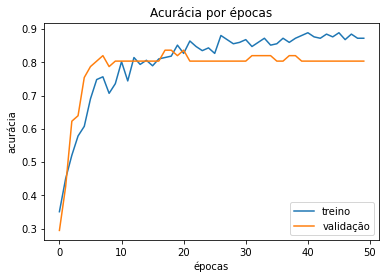

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])


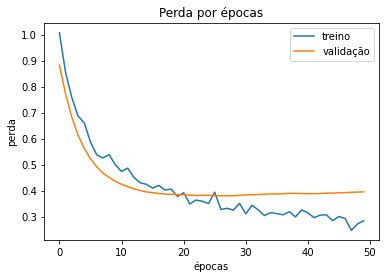

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])

Chegamos a uma precisão de **78%** de precisão de validação

**Inferência sobre novos dados**


In [21]:
sample = {
    "age": 20,
    "sex": 0,
    "cp": 4,
    "trestbps": 159,
    "chol": 280,
    "fbs": 1,
    "restecg": 2,
    "thalach": 170,
    "exang": 1,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "Este paciente em particular tem uma probabilidade de %.1f por cento "
    "de ter uma doença cardíaca, conforme avaliado pelo nosso modelo." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 33ms/step
Este paciente em particular tem uma probabilidade de 77.3 por cento de ter uma doença cardíaca, conforme avaliado pelo nosso modelo.


In [23]:
!pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.3/471.3 kB 5.2 MB/s eta 0:00:00


In [24]:
# mongodb
from pymongo import MongoClient

# salva arquivos no mongodb
import gridfs
import io
from bson import ObjectId

# exibe as imagens utilizadas como input para inferencia do modelo treinado
from IPython.display import Image, display

In [81]:
db = 'sprint3'
client = 'mongodb://localhost:27017/'
collection = 'mycollection'
model_name = "teste"


In [117]:
import pickle
import time
import pymongo

def save_model_to_mongo(model, model_name, client, db, collection):

    myclient = pymongo.MongoClient(client)
    mydb = myclient[db]
    mycon = mydb[collection]

    pickle_model = pickle.dumps(model)

    result = mycon.insert_one({'model': pickle_model,'model_name':model_name, 'create_at':time.time()})
    print(result.inserted_id, "success")
    print(result)
    details = {
        'id': result.inserted_id,
        'model_name': model_name,
        'created_at': time.time()
    }

    return details


In [118]:
save_model_to_mongo(client=client,collection=collection,db=db,model=model,model_name='modelo')

INFO:tensorflow:Assets written to: ram://15588c16-6075-438e-b0e3-fbffe79161b2/assets
62ae2044ddbe0152fb2d5c08 success


{'id': ObjectId('62ae2044ddbe0152fb2d5c08'),
 'model_name': 'modelo',
 'created_at': 1655578692.614011}

In [128]:
def load_saved_model_from_mongo(model_name, client, db, collection):
    
    json_result= {}

    myclient = pymongo.MongoClient(client)
    mydb = myclient[db]
    mycon = mydb[collection]

    result = mycon.find({})
    for i in result:
        json_result = i


    pickled_model = json_result['model']

    return pickle.loads(pickled_model)

In [130]:


model_from_mongo = load_saved_model_from_mongo(model_name=model_name, client=client, db=db, collection=collection)

In [131]:
sample = {
    "age": 20,
    "sex": 0,
    "cp": 4,
    "trestbps": 159,
    "chol": 280,
    "fbs": 1,
    "restecg": 2,
    "thalach": 170,
    "exang": 1,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model_from_mongo.predict(input_dict)

print(
    "Este paciente em particular tem uma probabilidade de %.1f por cento "
    "de ter uma doença cardíaca, conforme avaliado pelo nosso modelo." % (100 * predictions[0][0],)
)

1/1 [==============================] - 1s 1s/step
Este paciente em particular tem uma probabilidade de 77.3 por cento de ter uma doença cardíaca, conforme avaliado pelo nosso modelo.
